In [189]:
# helper functions

import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

def convert_color_space(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: return np.copy(img)  

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        img = mpimg.imread(file)
        
        file_features = single_img_features(img, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)
        
        features.append(file_features)
    # Return list of feature vectors
    return features


In [506]:
# model training data set

import glob

# Read in car images
gti_images = glob.glob('vehicles/GTI*/*.png')
kitti_images = glob.glob('vehicles/KITTI*/*.png')
images = gti_images + kitti_images
cars = [image for image in images]
print(len(cars))

# Read in non-car images
gti_images = glob.glob('non-vehicles/GTI/*.png')
extra_images = glob.glob('non-vehicles/Extras/*.png')
images = gti_images + extra_images
notcars = [image for image in images]
print(len(notcars))




8792
8968


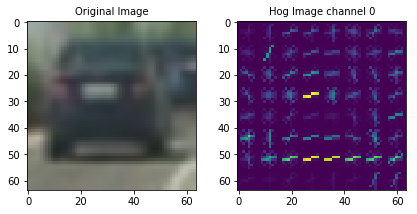

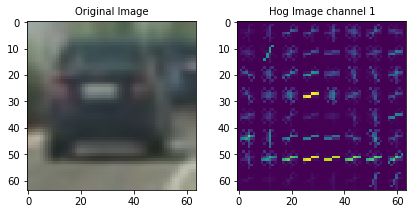

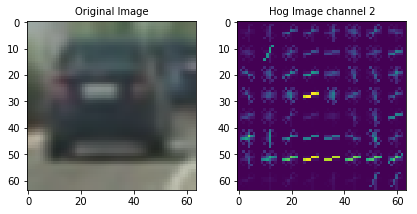

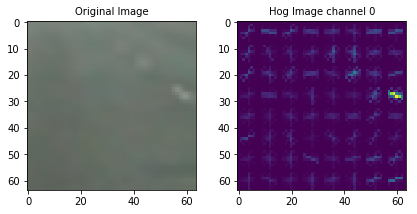

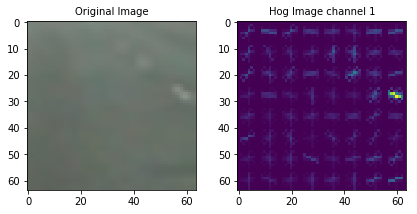

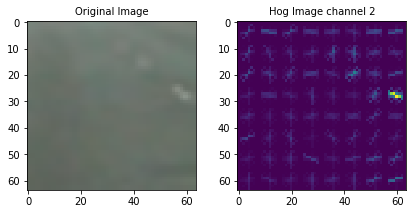

In [384]:
# Hog images

orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

car_img = mpimg.imread(cars[0])
non_car_img = mpimg.imread(notcars[0])

plt.figure()
for img in [car_img, non_car_img]:
    for channel in range(3):
        features, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
 

        f, (ax1, ax2) = plt.subplots(1, 2)
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=10)
        ax2.imshow(hog_image)
        ax2.set_title('Hog Image channel ' + str(channel), fontsize=10)
        #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

In [507]:
# train model

import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # (16, 16) Spatial binning dimensions
hist_bins = 32    # 16 Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, hog_channel=hog_channel,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, hog_channel=hog_channel,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 8460
16.3 Seconds to train SVC...
Test Accuracy of SVC =  0.9876
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
0.02292 Seconds to predict 10 labels with SVC


In [508]:
# sliding window function

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def slide_window_2(img, x_start_stop=(0,1280), y_start_stop=(0,960), 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Helper function Search cars in images using specified list of windows
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

(0, 1280) (400, 656) (128, 128)
(200, 1280) (400, 600) (96, 96)
(200, 1280) (400, 530) (64, 64)


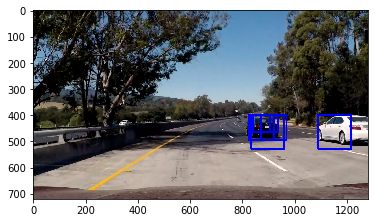

In [517]:
# Search cars in images using specified list of windows


import matplotlib.pyplot as plt


image = mpimg.imread('test_images/test5.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

#xy_window = (128, 128) # (96, 96)
#y_start_stop = [400, 650] # Min and max in y to search in slide_window()

x_start_stop = [(0, 1280),(200, 1280),(200, 1280)]
y_start_stop = [(400,656), (400,600), (400,530)]
xy_window = [(128,128), (96, 96), (64,64)]

windows = []

for x_ss, y_ss, xy_w in zip(x_start_stop, y_start_stop, xy_window):
    print(x_ss, y_ss, xy_w)
    w = slide_window_2(image, x_start_stop=x_ss, y_start_stop=y_ss, 
                        xy_window=xy_w, xy_overlap=(0.5, 0.5))
    windows += w
                  

# uses same params as in training
# color_space = 'YCrCb'
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.show()
fig.savefig('output_images/windows.jpg')

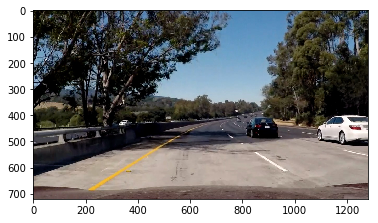

In [510]:


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color_space(img, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                startx = xbox_left
                starty = ytop_draw+ystart
                endx = xbox_left+win_draw
                endy = ytop_draw+win_draw+ystart
                window_list.append(((startx, starty), (endx, endy)))
                
                
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, window_list

# uses same paramns as in training
ystart = 400
ystop = 650
scale = 5

out_img, candidate_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()

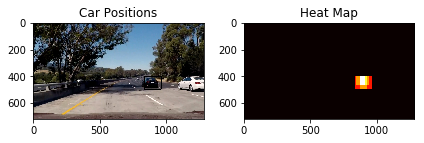

In [518]:
# heatmaps

from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
threshold = 1
heat = apply_threshold(heat,threshold)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()
fig.savefig('output_images/heatmap.jpg')

In [512]:
# to apply heatmap to multiple frames

class CarWindows:
    
    def __init__(self, num_frames):
        self.windows = []
        self.num_frames = num_frames
        
    def add_windows(self, w):
    
        self.windows.append(w)
        self.windows = self.windows[-self.num_frames:]
       
        
    def get_windows(self):
        return [w for ws in self.windows for w in ws]
    
        

        
c = CarWindows(3)
c.add_windows([4,5,6])
c.add_windows([7,8,9])
c.add_windows([6,6,6])
c.add_windows([7,7,7])
print(c.get_windows())

[7, 8, 9, 6, 6, 6, 7, 7, 7]


In [513]:
#define pipeline

past_windows = CarWindows(6)

last_windows = []

def process_frame(img):
    
    draw_img = np.copy(img)
    
    img = img.astype(np.float32)/255

    windows = []
    for x_ss, y_ss, xy_w in zip(x_start_stop, y_start_stop, xy_window):
        w = slide_window_2(image, x_start_stop=x_ss, y_start_stop=y_ss, 
                            xy_window=xy_w, xy_overlap=(0.5, 0.5))
        windows += w

    # uses same params as in training
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  


    # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # keep past windows
    #last_windows.append(hot_windows)
    #last_windows = last_windows[-6:]
    #heat = add_heat(heat,[w for windows in last_windows for w in windows])
    
    # keep windows
    past_windows.add_windows(hot_windows)
    p_windows = past_windows.get_windows()
    heat = add_heat(heat,p_windows)
    
    # Apply threshold to help remove false positives
    threshold = 4
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return draw_labeled_bboxes(draw_img, labels)
    

test1.jpg


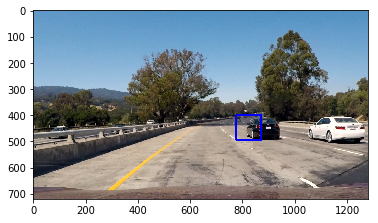

test2.jpg


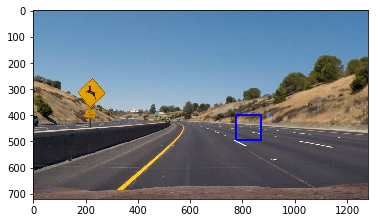

test3.jpg


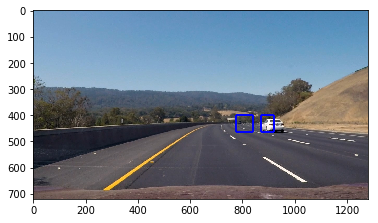

test4.jpg


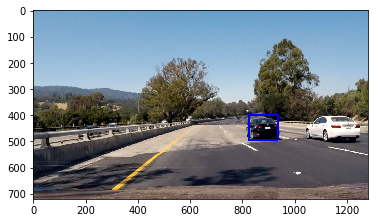

test5.jpg


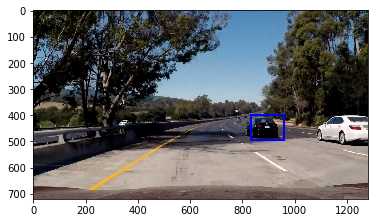

test6.jpg


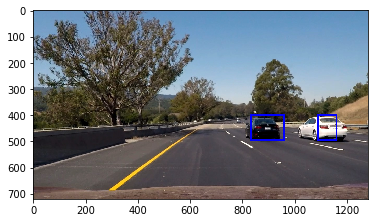

In [519]:
# apply complete pipeline to all test images

import os

for image in os.listdir("test_images/"):
    
    if 'DS' in image:
        continue
    print(image)
    
    img = mpimg.imread('test_images/' + image)
    
    fig = plt.figure()
    result = process_frame(img)
    plt.imshow(result)
    plt.show()
    fig.savefig('output_images/pipeline_' + image)
    

In [520]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

v_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(v_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [2:03:23<00:00,  1.07it/s]     


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 18min 31s, sys: 18.6 s, total: 18min 50s
Wall time: 2h 3min 24s


In [521]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(v_output))